In [1]:
import numpy as np     #只需要下载numpy库即可
import random
import GridWorld_v2
import time
from IPython.display import clear_output

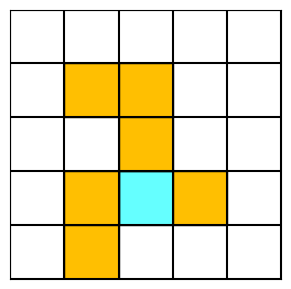

In [2]:
rows = 5      #记得行数和列数这里要同步改
columns = 5
gridworld = GridWorld_v2.GridWorld_v2(forbidden_area_score=-10, score=1,desc = [".....",".##..","..#..",".#T#.",".#..."]) 
gridworld.show()

In [3]:
value = np.zeros(rows*columns).reshape(rows,columns)       #初始化可以任意，也可以全0
q_table = np.zeros((rows*columns,5)).reshape(rows,columns,5)  #初始化，这里主要是初始化维数，里面的内容会被覆盖所以无所谓

In [4]:
def take_action(state,epsilon):
    if np.random.random() < epsilon:
        action = np.random.randint(0,5)
    else:
        action = np.argmax(q_table[state[0],state[1]])
    return action

In [5]:
def expect_sarsa(gridworld:GridWorld_v2.GridWorld_v2,gamma = 0.99,trajectorySteps=-1, learning_rate=0.001, final_epsilon=0.01, num_episodes=600)->GridWorld_v2.GridWorld_v2:
    """
    这是最基础的SARSA算法

    Parameters:
    trajectorySteps (int): 寻路的轨迹长度，如果是-1，则为寻到目的则停止，否则参数即为trajectory长度
    learning_rate (float): 学习率，用于调节TD-target
    epsilon (float): epsilon-greedy的核心参数，0~1的浮点数，其中1则表示当前state所有决策概率一样，0则表示决策没有任何的随机性
    num_episodes (int): 表示模型迭代次数

    Returns:
    GridWorld_v2.GridWorld_v2: 把模型返回回去
    """
    
    state_value = np.zeros((rows * columns)).reshape(gridworld.rows,gridworld.columns)
    # initialize q table
    # initialize policy
    policy = np.eye(5)[np.random.randint(0,5,size=(rows*columns))].reshape(gridworld.rows,gridworld.columns,5) 
    epsilon = 0.5
    for episode in range(1000):
        #清除输出，可以更好的展示策略
        print("episode",f"{episode}/{num_episodes}")
        if(epsilon > final_epsilon) :
            epsilon -= 0.001
        else:
            epsilon = final_epsilon

        #cnt数组用来检查每个state有多少次访问
        
        # initialize state
        init_state=(0,0)
        init_action=random.randint(0,4)  
        print("init_state",init_state)
        print("init_action",init_action)
        reward = 0
        next_state = init_state
        next_action = init_action

        while(reward != 1):
        # get next state and reward

            now_state = next_state
            now_action = next_action
            reward,next_state = gridworld.step(now_state,now_action)
            next_action = take_action(next_state,epsilon)
            td_target = reward + gamma * (q_table[next_state[0],next_state[1]] )
            td_error = q_table[now_state[0],now_state[1],now_action] - td_target
            q_table[now_state[0],now_state[1],now_action] -= learning_rate * td_error
            if reward == 1:
                now_action = 4
                now_state = next_state
                td_target = 1 + gamma * (q_table[now_state[0],now_state[1]].mean() )
                td_error = q_table[now_state[0],now_state[1],now_action] - td_target
                q_table[now_state[0],now_state[1],now_action] -= learning_rate * td_error

    
        policy = q_table.argmax(axis=2)
        state_value = np.max(q_table,axis=2)

        # print("mean_state_value", mean_state_value)

    gridworld.show_policy(policy,step=False)
    gridworld.show_value(state_value)
    print(state_value.shape)
    return q_table
    

In [6]:
expect_sarsa(gridworld)

episode 0/600
init_state (0, 0)
init_action 1


ValueError: too many values to unpack (expected 2)